# MNIST Classifier with SimpleNet 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [2]:
BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST training set
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split the dataset into train and eval sets
train_size = 50000
eval_size = 10000
train_subset, eval_subset = random_split(train_dataset, [train_size, eval_size])

# Load the MNIST test set
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders for each dataset
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(eval_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [3]:
len(train_loader), len(eval_loader), len(test_loader)

(782, 157, 157)

## Faza 2

[GitHub Repo](https://github.com/Coderx7/SimpleNet_Pytorch/blob/master/cifar/models/simplenet.py) for simplenet310k - cel folosit pt MNIST

In procesul de evaluare, in setul de test, de salvat imaginile care au fost prezise incorect de catre model, cu tuple: `idx`, `clasa prezisa`, `clasa adevarata`. 
De salvat imaginile intr-un director separat format de genul: `"im14_0_9"`.

Pentru a incarca pe fork-ul de pe github: `git push origin master`



In [4]:
# import sys

# # Add the directory to the Python path in this notebook 
# sys.path.append('/home/iustin/pytorch-cnn-visualizations')

# from models.simplenet import simplenet_cifar_310k

In [4]:
import os 
os.chdir('/home/iustin/pytorch-cnn-visualizations')
os.getcwd()

'/home/iustin/pytorch-cnn-visualizations'

In [5]:
from models.simplenet import simplenet_cifar_310k

In [6]:
import models

model_names = sorted(name for name in models.__dict__
  if name.islower() and not name.startswith("__")
  and callable(models.__dict__[name]))

print('models : ',model_names)

models :  ['simplenet_cifar_310k', 'simplenet_cifar_460k', 'simplenet_cifar_5m', 'simplenet_cifar_5m_extra_pool']


In [7]:
net = models.__dict__['simplenet_cifar_310k'](num_classes=10, in_chans=1)

In [8]:
from torchinfo import summary

summary(net, 
        input_size=(1, 1, 28, 28), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleNet (SimpleNet)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (features)                  [1, 1, 28, 28]       [1, 64, 1, 1]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 64, 28, 28]      640                  True
│    └─BatchNorm2d (1)                   [1, 64, 28, 28]      [1, 64, 28, 28]      128                  True
│    └─ReLU (2)                          [1, 64, 28, 28]      [1, 64, 28, 28]      --                   --
│    └─Dropout2d (3)                     [1, 64, 28, 28]      [1, 64, 28, 28]      --                   --
│    └─Conv2d (4)                        [1, 64, 28, 28]      [1, 32, 28, 28]      18,464               True
│    └─BatchNorm2d (5)                   [1, 32, 28, 28]      [1, 32, 28, 28]      64                   True
│    └─ReLU (6)   

In [32]:
net.eval()
input_dummy = torch.randn(size=(1, 1, 28, 28)).to(device)
out = net(input_dummy)
print(f"output: {out.size()}")

output: torch.Size([1, 10])


In [9]:
LEARNING_RATE = 0.1
MOMENTUM = 0.9 # default 
WEIGHT_DECAY = 0 # 0.005 
NUM_EPOCH = 25 # 150
EVAL_STEP = 1
SAVE_INTERVAL = 1 # checkpoint
MILESTONES = [20, 40, 60, 80, 100, 120]
STEP_SIZE= 20 # intre 10 si 100 la scheduler step_lr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available

net = net.to(device)

criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adadelta(net.parameters(), lr=LEARNING_RATE, rho=0.9, eps=1e-3, # momentum=state['momentum'], # default eps = 1e-6 
                                    #  weight_decay=0.001)

optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY) 
# optimizer = torch.optim.Adam(net.parameters(),lr=LEARNING_RATE,betas=(0.9,0.999),eps=1e-08,weight_decay=0)

# scheduler = lr_scheduler.MultiStepLR(optimizer, MILESTONES, gamma=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=0.1)

In [ ]:
PATH1 = "checkpoints/checkpoint_loss"
PATH2 = "checkpoints/checkpoint_acc"

checkpoint_filename = 'checkpoint.pth'
checkpoint_path1 = os.path.join(PATH1, checkpoint_filename)
checkpoint_path2 = os.path.join(PATH2, checkpoint_filename)

In [ ]:
def train(net, device, train_loader, criterion, optimizer, train_loss_collector, train_accuracy_collector):
     for epoch in range(NUM_EPOCH):
        net.train()
        correct = 0
        epoch_loss = list()
        eval_loss = list()
        accuracy = list() 
        eval_accuracy = list()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            pred = torch.max(output.data, 1)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            accuracy.append(correct)
            epoch_accuracy =  100. * correct / len(train_loader.dataset)
        train_loss_collector.append(np.round(np.mean(epoch_loss),5))
        train_accuracy_collector.append(epoch_accuracy)
        print(f'Epoch: {epoch}/{NUM_EPOCH} \t Loss: {np.round(np.mean(epoch_loss),5)}')
        print(f'Train Accuracy: {(100. * correct / len(train_loader.dataset)):.3f}%')
        scheduler.step()
        if epoch % EVAL_STEP == 0:
            evaluation(net, device, eval_loader, criterion, eval_loss_collector, eval_accuracy_collector)
        if epoch % SAVE_INTERVAL == 0: 
            torch.save({
                'epoch': epoch,
                'net_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch_loss': epoch_loss,
                'eval_loss': eval_loss,
                'train_loss_collector': train_loss_collector,
                'eval_loss_collector': eval_loss_collector,
                'all_preds': all_preds,
                'all_targets': all_targets,
                'LEARNING_RATE': LEARNING_RATE,
                'MOMENTUM': MOMENTUM,
                'WEIGHT_DECAY': WEIGHT_DECAY,
                'NUM_EPOCH': NUM_EPOCH,
                'EVAL_STEP': EVAL_STEP,
                'SAVE_INTERVAL': SAVE_INTERVAL,
                'MILESTONES': MILESTONES,
                'STEP_SIZE': STEP_SIZE,
            }, checkpoint_path1)
            torch.save({
                'epoch': epoch,
                'net_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch_accuracy': epoch_accuracy,
                'eval_accuracy': eval_accuracy,
                'train_accuracy_collector': train_accuracy_collector,
                'eval_accuracy_collector': eval_accuracy_collector,
                'all_preds': all_preds,
                'all_targets': all_targets,
                'LEARNING_RATE': LEARNING_RATE,
                'MOMENTUM': MOMENTUM,
                'WEIGHT_DECAY': WEIGHT_DECAY,
                'NUM_EPOCH': NUM_EPOCH,
                'EVAL_STEP': EVAL_STEP,
                'SAVE_INTERVAL': SAVE_INTERVAL,
                'MILESTONES': MILESTONES,
                'STEP_SIZE': STEP_SIZE,
            }, checkpoint_path2)

In [ ]:
def evaluation(net, device, eval_loader, criterion, eval_loss_collector, eval_accuracy_collector):
    net.eval() 
    correct_eval = 0
    eval_loss = list()
    eval_acc = list()
    with torch.no_grad():
        for data, target in eval_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            loss = criterion(output, target)
            eval_loss.append(loss.item())
            preds = output.argmax(dim=1, keepdim=True)
            correct_eval += preds.eq(target.view_as(preds)).sum().item()
            eval_acc.append(correct_eval)
            eval_accuracy =  100. * correct_eval / len(eval_loader.dataset)
        eval_loss_collector.append(np.round(np.mean(eval_loss),5))
        eval_accuracy_collector.append(eval_accuracy)
        print(f'Eval loss: {np.round(np.mean(eval_loss), 5)} Eval Accuracy: {correct_eval}/{len(eval_loader.dataset)}'
              f' - {(100. * correct_eval / len(eval_loader.dataset)):.3f}%')
    all_preds.extend(preds)
    all_targets.extend(target)

In [ ]:
train_loss_collector = list()
train_accuracy_collector = list()
eval_loss_collector = list()
eval_accuracy_collector = list()
all_preds = list()
all_targets = list()
print('Start training...')
train(net, device, train_loader, criterion, optimizer, train_loss_collector, train_accuracy_collector)
print('Finish training!')

Start training...
Epoch: 0/25 	 Loss: 0.13282
Train Accuracy: 96.044%
Eval loss: 0.08343 Eval Accuracy: 9787/10000 - 97.870%
Epoch: 1/25 	 Loss: 0.04561
Train Accuracy: 98.672%
Eval loss: 0.04493 Eval Accuracy: 9859/10000 - 98.590%
Epoch: 2/25 	 Loss: 0.03159
Train Accuracy: 99.086%
Eval loss: 0.03255 Eval Accuracy: 9895/10000 - 98.950%
Epoch: 3/25 	 Loss: 0.02449
Train Accuracy: 99.320%
Eval loss: 0.05649 Eval Accuracy: 9842/10000 - 98.420%
Epoch: 4/25 	 Loss: 0.02135
Train Accuracy: 99.340%
Eval loss: 0.03026 Eval Accuracy: 9915/10000 - 99.150%
Epoch: 5/25 	 Loss: 0.01531
Train Accuracy: 99.548%
Eval loss: 0.02994 Eval Accuracy: 9907/10000 - 99.070%
Epoch: 6/25 	 Loss: 0.01349
Train Accuracy: 99.600%
Eval loss: 0.02683 Eval Accuracy: 9921/10000 - 99.210%
Epoch: 7/25 	 Loss: 0.011
Train Accuracy: 99.622%
Eval loss: 0.02598 Eval Accuracy: 9926/10000 - 99.260%
Epoch: 8/25 	 Loss: 0.01149
Train Accuracy: 99.662%
Eval loss: 0.05092 Eval Accuracy: 9859/10000 - 98.590%
Epoch: 9/25 	 Loss: 0

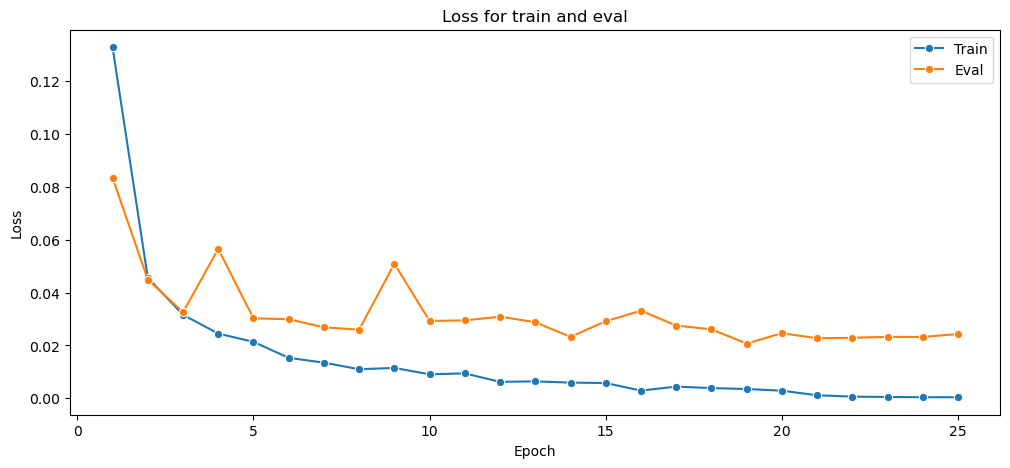

In [ ]:
plt.figure(figsize=(12,5))
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=train_loss_collector, label='Train', marker='o')
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=eval_loss_collector, label='Eval', marker='o')
plt.title('Loss for train and eval')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show();

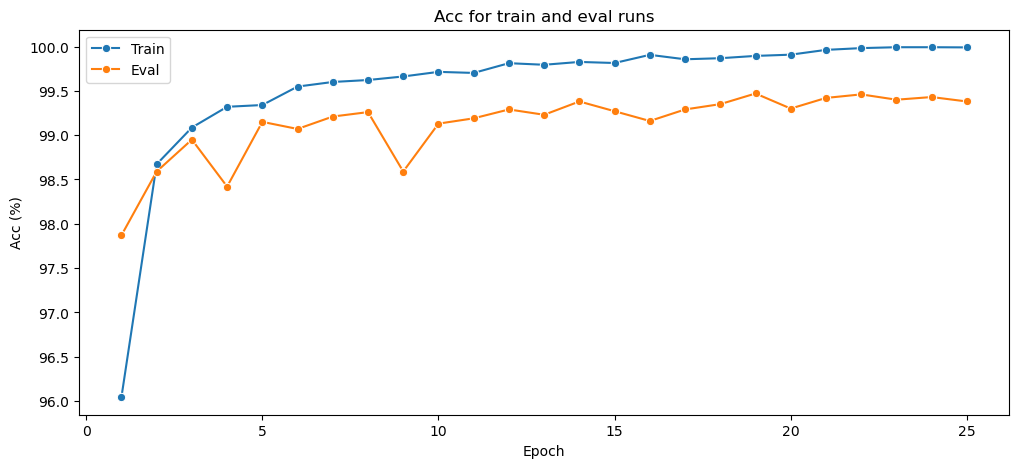

In [ ]:
plt.figure(figsize=(12,5))
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=train_accuracy_collector, label='Train', marker='o')
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=eval_accuracy_collector, label='Eval', marker='o')
plt.title('Acc for train and eval runs')
plt.ylabel('Acc (%)')
plt.xlabel('Epoch')
plt.show();

In [10]:
# load checkpoints
checkpoint_path1 = "checkpoints/checkpoint_loss/checkpoint.pth"
checkpoint = torch.load(checkpoint_path1)
net.load_state_dict(checkpoint['net_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
all_preds = checkpoint['all_preds']
all_targets = checkpoint['all_targets']
train_loss_collector = checkpoint['train_loss_collector']
eval_loss_collector = checkpoint['eval_loss_collector']

checkpoint_path2 = "checkpoints/checkpoint_acc/checkpoint.pth"
checkpoint = torch.load(checkpoint_path2)
net.load_state_dict(checkpoint['net_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
all_preds = checkpoint['all_preds']
all_targets = checkpoint['all_targets']
train_accuracy_collector = checkpoint['train_accuracy_collector']
eval_accuracy_collector = checkpoint['eval_accuracy_collector']

In [ ]:
# checkpoint

In [14]:
data = {
    'Train Loss': train_loss_collector,
    'Train Accuracy': train_accuracy_collector,
    'Eval Loss': eval_loss_collector,
    'Eval Accuracy': eval_accuracy_collector
}

df = pd.DataFrame(data)

df.index.name = 'Epoch'

print(df)

       Train Loss  Train Accuracy  Eval Loss  Eval Accuracy
Epoch                                                      
0         0.13282          96.044    0.08343          97.87
1         0.04561          98.672    0.04493          98.59
2         0.03159          99.086    0.03255          98.95
3         0.02449          99.320    0.05649          98.42
4         0.02135          99.340    0.03026          99.15
5         0.01531          99.548    0.02994          99.07
6         0.01349          99.600    0.02683          99.21
7         0.01100          99.622    0.02598          99.26
8         0.01149          99.662    0.05092          98.59
9         0.00907          99.714    0.02927          99.13
10        0.00944          99.702    0.02948          99.19
11        0.00622          99.812    0.03089          99.29
12        0.00641          99.794    0.02878          99.23
13        0.00593          99.826    0.02323          99.38
14        0.00579          99.814    0.0

In [15]:
# pe jupyterhub
file_path = 'training_test_metrics.csv' 
df.to_csv(file_path, index=True)

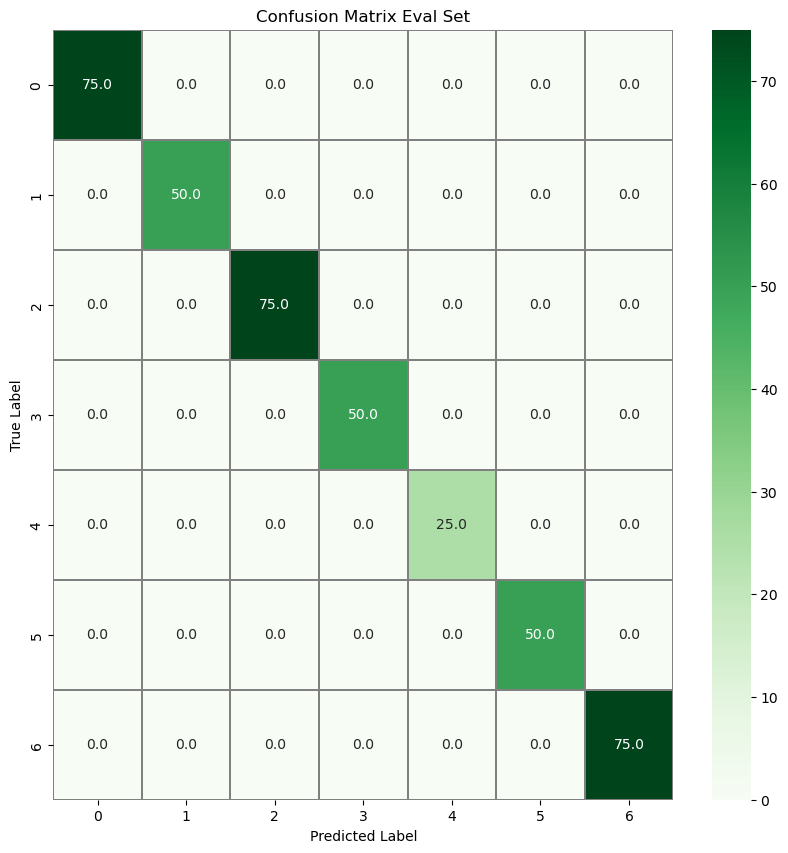

In [16]:
preds = [tensor.item() for tensor in all_preds]
targets = [tensor.item() for tensor in all_targets]
confusion_mtx = confusion_matrix(targets, preds)
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Eval Set")
plt.show()

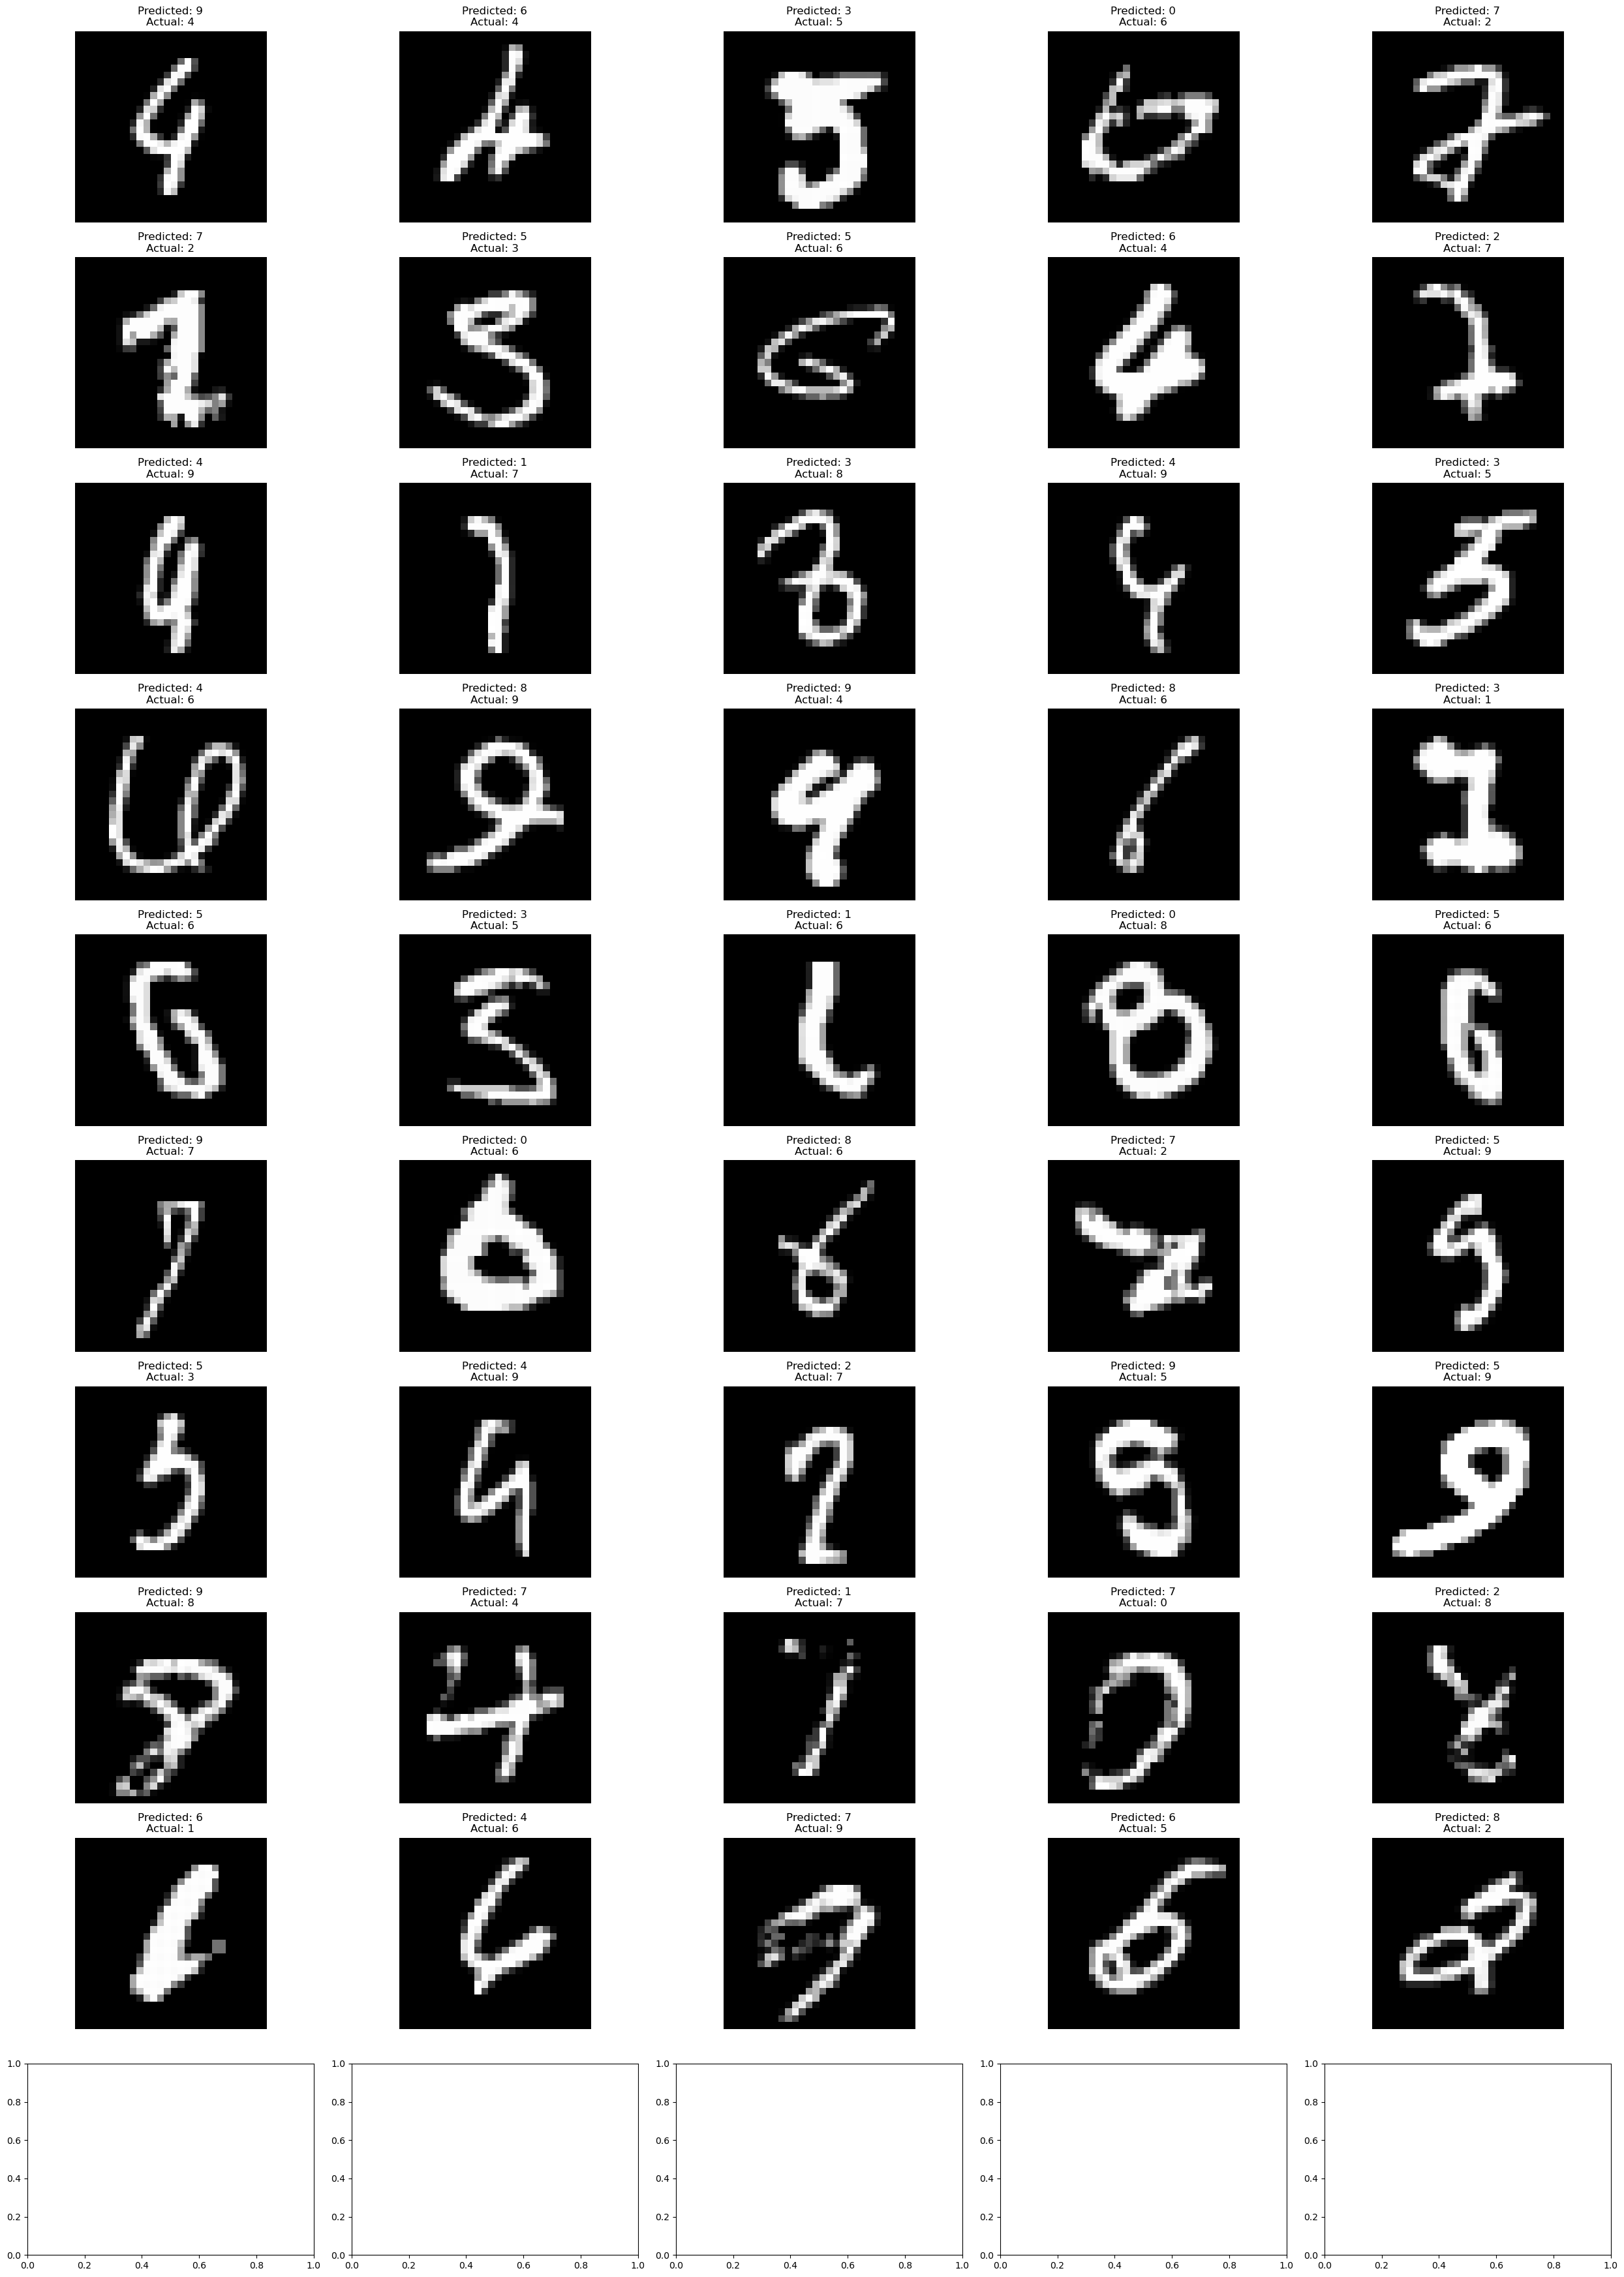

In [11]:
def plot_misclassified_images(net, device, test_loader, classes):
    net = net.to(device)
    net.eval()  
    misclassified = []

    with torch.no_grad(): 
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            pred = output.argmax(dim=1, keepdim=True)  

            # Check for misclassified images
            misclassified_mask = ~pred.eq(target.view_as(pred))
            misclassified_images = data[misclassified_mask]
            misclassified_preds = pred[misclassified_mask]
            misclassified_targets = target.view_as(pred)[misclassified_mask]

            # Store the misclassified images and their predicted/actual labels
            for image, pred, actual in zip(misclassified_images, misclassified_preds, misclassified_targets):
                misclassified.append((image, pred, actual))

            # Stop after collecting a certain number of misclassified images
            if len(misclassified) >= 50:
                break

    # Plot the misclassified images
    fig, axes = plt.subplots(10, 5, figsize=(25, 35))
    for i, (image, pred, actual) in enumerate(misclassified[:50]):
        ax = axes[i//5, i%5]
        ax.imshow(image.cpu().numpy().squeeze(), cmap='gray')
        ax.set_title(f'Predicted: {classes[pred.item()]}\nActual: {classes[actual.item()]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_misclassified_images(net, device, test_loader, classes)

> ! 35 imagini misclassified pe test set si 36 in procesul de antrenare pe setul de eval

In [ ]:
from pathlib import Path
from PIL import Image
def save_misclassified_samples(net, device, test_loader, save_dir):
    net.eval()  
    misclassified_samples = []

    with torch.no_grad():  
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            pred = output.argmax(dim=1, keepdim=True)  

            # Check for misclassified images
            misclassified_mask = ~pred.eq(target.view_as(pred))
            misclassified_data = data[misclassified_mask].cpu()
            misclassified_targets = target[misclassified_mask.squeeze()].cpu()

            for img, label in zip(misclassified_data, misclassified_targets):
                misclassified_samples.append((img, label.item()))
    # Save the misclassified images to the set path
    if misclassified_samples:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        for i, (img, label) in enumerate(misclassified_samples):
            img = transforms.ToPILImage()(img.squeeze())
            # Convert grayscale image to RGB with a single channel
            img = img.convert('L')  
            image_3_channel = np.stack((img,)*3, axis=-1)
            image_3_channel_pil = Image.fromarray(image_3_channel)
            # Save 
            image_3_channel_pil.save(save_dir / f'misclassified_{i}_{label}.jpeg')
    else:
        return None
save_misclassified_samples(net.to(device), device, test_loader, 'misclassified_samples')

In [17]:
os.chdir('/home/iustin/pytorch-cnn-visualizations')
os.getcwd()

'/home/iustin/pytorch-cnn-visualizations'

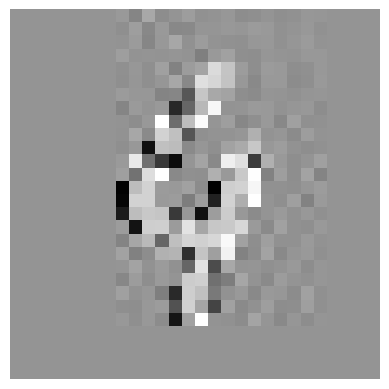

In [18]:
image_path = 'misclassified_samples/misclassified_0_4.jpeg'
image = Image.open(image_path)

# Display the image
plt.imshow(image)  # Use cmap='gray' if it's a grayscale image
plt.axis('off')  
plt.show()

3. https://github.com/utkuozbulak/pytorch-cnn-visualizations

Guided backprop and CNN layer visualization

packages for repo codespace: 

torch==2.1.0
torchvision==0.16.0
numpy==1.26.1
matplotlib==3.7.2
pillow(PIL)==9.5.0

In github codespace am creat un environment cu package-urile de mai sus si am replicat intr-un test.ipynb rezultatele din guided_backprop.py.

S-a creat si fork pe contul meu, deci merge sa il rulez local si eventual sa pasez direct imaginile, daca merge.

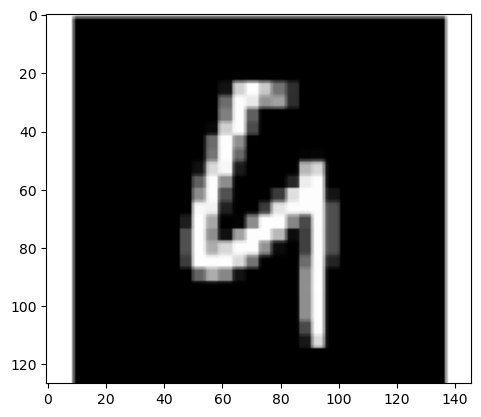

In [19]:
image_path = 'input_images/digit_4.png'
image = Image.open(image_path)
plt.imshow(image)

Guided Backpropagation pe output image

In [21]:
from src.misc_functions import get_example_params, save_gradient_images, convert_to_grayscale, get_positive_negative_saliency
from src.guided_backprop import GuidedBackprop
import src.layer_activation_with_guided_backprop

target_example = 1  # digit 4 
(original_image, prep_img, target_class, file_name_to_export, net) =\
    get_example_params(target_example)

# Guided backprop
GBP = GuidedBackprop(net)
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)
# Save colored gradients
save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Save grayscale gradients
save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
print('Guided backprop completed')

models :  ['simplenet_cifar_310k', 'simplenet_cifar_460k', 'simplenet_cifar_5m', 'simplenet_cifar_5m_extra_pool']
Guided backprop completed


Layer Guided Backpropagation pe output image

In [ ]:
cnn_layer = 13
filter_pos = 5
target_example = 1  # digit 7
(original_image, prep_img, target_class, file_name_to_export, net) =\
    get_example_params(target_example)

# File export name
file_name_to_export = file_name_to_export + '_layer' + str(cnn_layer) + '_filter' + str(filter_pos)
# Guided backprop
GBP = GuidedBackprop(net)
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)
# Save colored gradients
save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Save grayscale gradients
save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
print('Layer Guided backprop completed')    

models :  ['simplenet_cifar_310k', 'simplenet_cifar_460k', 'simplenet_cifar_5m', 'simplenet_cifar_5m_extra_pool']
Layer Guided backprop completed


CNN Layer Visualization pe random image (randn input)

In [20]:
os.chdir('/home/iustin/pytorch-cnn-visualizations/generated/')
os.getcwd()

'/home/iustin/pytorch-cnn-visualizations/generated'

In [28]:
from src.cnn_layer_visualization import CNNLayerVisualization

cnn_layer = 52
filter_pos = 63
# Fully connected layer is not needed
# pretrained_model = models.vgg16(pretrained=True).features
net = models.__dict__['simplenet_cifar_310k'](num_classes=10, in_chans=1)
layer_vis = CNNLayerVisualization(net, cnn_layer, filter_pos)

# Layer visualization with pytorch hooks
layer_vis.visualise_layer_with_hooks()

# Layer visualization without pytorch hooks
# layer_vis.visualise_layer_without_hooks()

could not transform PIL_img to a PIL Image object. Please check input.
Iteration: 1 Loss: 0.29
Iteration: 2 Loss: 0.28
Iteration: 3 Loss: 0.28
Iteration: 4 Loss: 0.26
Iteration: 5 Loss: 0.25
Iteration: 6 Loss: 0.23
Iteration: 7 Loss: 0.22
Iteration: 8 Loss: 0.21
Iteration: 9 Loss: 0.20
Iteration: 10 Loss: 0.18
Iteration: 11 Loss: 0.17
Iteration: 12 Loss: 0.16
Iteration: 13 Loss: 0.15
Iteration: 14 Loss: 0.14
Iteration: 15 Loss: 0.13
Iteration: 16 Loss: 0.13
Iteration: 17 Loss: 0.12
Iteration: 18 Loss: 0.11
Iteration: 19 Loss: 0.10
Iteration: 20 Loss: 0.10
Iteration: 21 Loss: 0.09
Iteration: 22 Loss: 0.08
Iteration: 23 Loss: 0.08
Iteration: 24 Loss: 0.07
Iteration: 25 Loss: 0.06
Iteration: 26 Loss: 0.06
Iteration: 27 Loss: 0.05
Iteration: 28 Loss: 0.05
Iteration: 29 Loss: 0.04
Iteration: 30 Loss: 0.04


In [29]:
cnn_layer = 52
for filter_pos in range(1, 64):
    layer_vis = CNNLayerVisualization(net, cnn_layer, filter_pos)
    layer_vis.visualise_layer_with_hooks()

could not transform PIL_img to a PIL Image object. Please check input.
Iteration: 1 Loss: 0.51
Iteration: 2 Loss: 0.51
Iteration: 3 Loss: 0.50
Iteration: 4 Loss: 0.48
Iteration: 5 Loss: 0.47
Iteration: 6 Loss: 0.45
Iteration: 7 Loss: 0.43
Iteration: 8 Loss: 0.42
Iteration: 9 Loss: 0.41
Iteration: 10 Loss: 0.39
Iteration: 11 Loss: 0.38
Iteration: 12 Loss: 0.37
Iteration: 13 Loss: 0.35
Iteration: 14 Loss: 0.34
Iteration: 15 Loss: 0.33
Iteration: 16 Loss: 0.32
Iteration: 17 Loss: 0.31
Iteration: 18 Loss: 0.30
Iteration: 19 Loss: 0.29
Iteration: 20 Loss: 0.28
Iteration: 21 Loss: 0.27
Iteration: 22 Loss: 0.26
Iteration: 23 Loss: 0.25
Iteration: 24 Loss: 0.24
Iteration: 25 Loss: 0.23
Iteration: 26 Loss: 0.23
Iteration: 27 Loss: 0.22
Iteration: 28 Loss: 0.21
Iteration: 29 Loss: 0.20
Iteration: 30 Loss: 0.19
could not transform PIL_img to a PIL Image object. Please check input.
Iteration: 1 Loss: 0.01
Iteration: 2 Loss: -0.02
Iteration: 3 Loss: -0.05
Iteration: 4 Loss: -0.08
Iteration: 5 Loss:

1. Am reusit sa generez attention maps cu GBP, GCAM si celelalte pentru o imagine de input cu cifra 4.
Acum urmeaza sa afisez pentru cateva imagini misclassified si sa vad daca alegerea modelului influenteaza in vreun fel attention map-ul.

2. Am reusit sa modific in guided_backprop.py si in misc_functions.py sa pot sa folosesc modelul SimpleNet si sa generez attention_maps pentru imaginile de input (cu cifra 4).

3. `cnn_layer_visualization.py` pentru layer visualization. modificat `hook_layer()` si `visualize_layer_with_hooks()` si in `misc_functions.py` am modificat `recreate_image()`

4. La rularea `cnn_layer_visualization` cu SGD ca optimizer, se face un forward si backward pass pentru 30 de epochs si se salveaza din 6 in 6 epochs imaginea, dar in prima faza afiseaza o imaginea alba de 6 ori + loss-ul in loop apare sa nu se modifice.

5. Am facut sa mearga si pe Visual Studio Code intr-un notebook in care am apelat toate script-urile necesare, dar tot am aceeasi problema cu generarea de imagini albe. 

6. Am reusit sa fac sa mearga `cnn_layer_visualization.py` cu simplenet, care genereaza 6 attention maps din 5 in 5 epochs pe o imagine cu input random. Nu pare sa fie nicio diferenta semnificativa intre metoda cu hooks si metoda fara hooks, decat loss-ul e diferit.

    

## Vizualizare cu Torchviz

[exemple cu torchviz](https://github.com/szagoruyko/pytorchviz/blob/master/examples.ipynb)

In [ ]:
from torchviz import make_dot, make_dot_from_trace

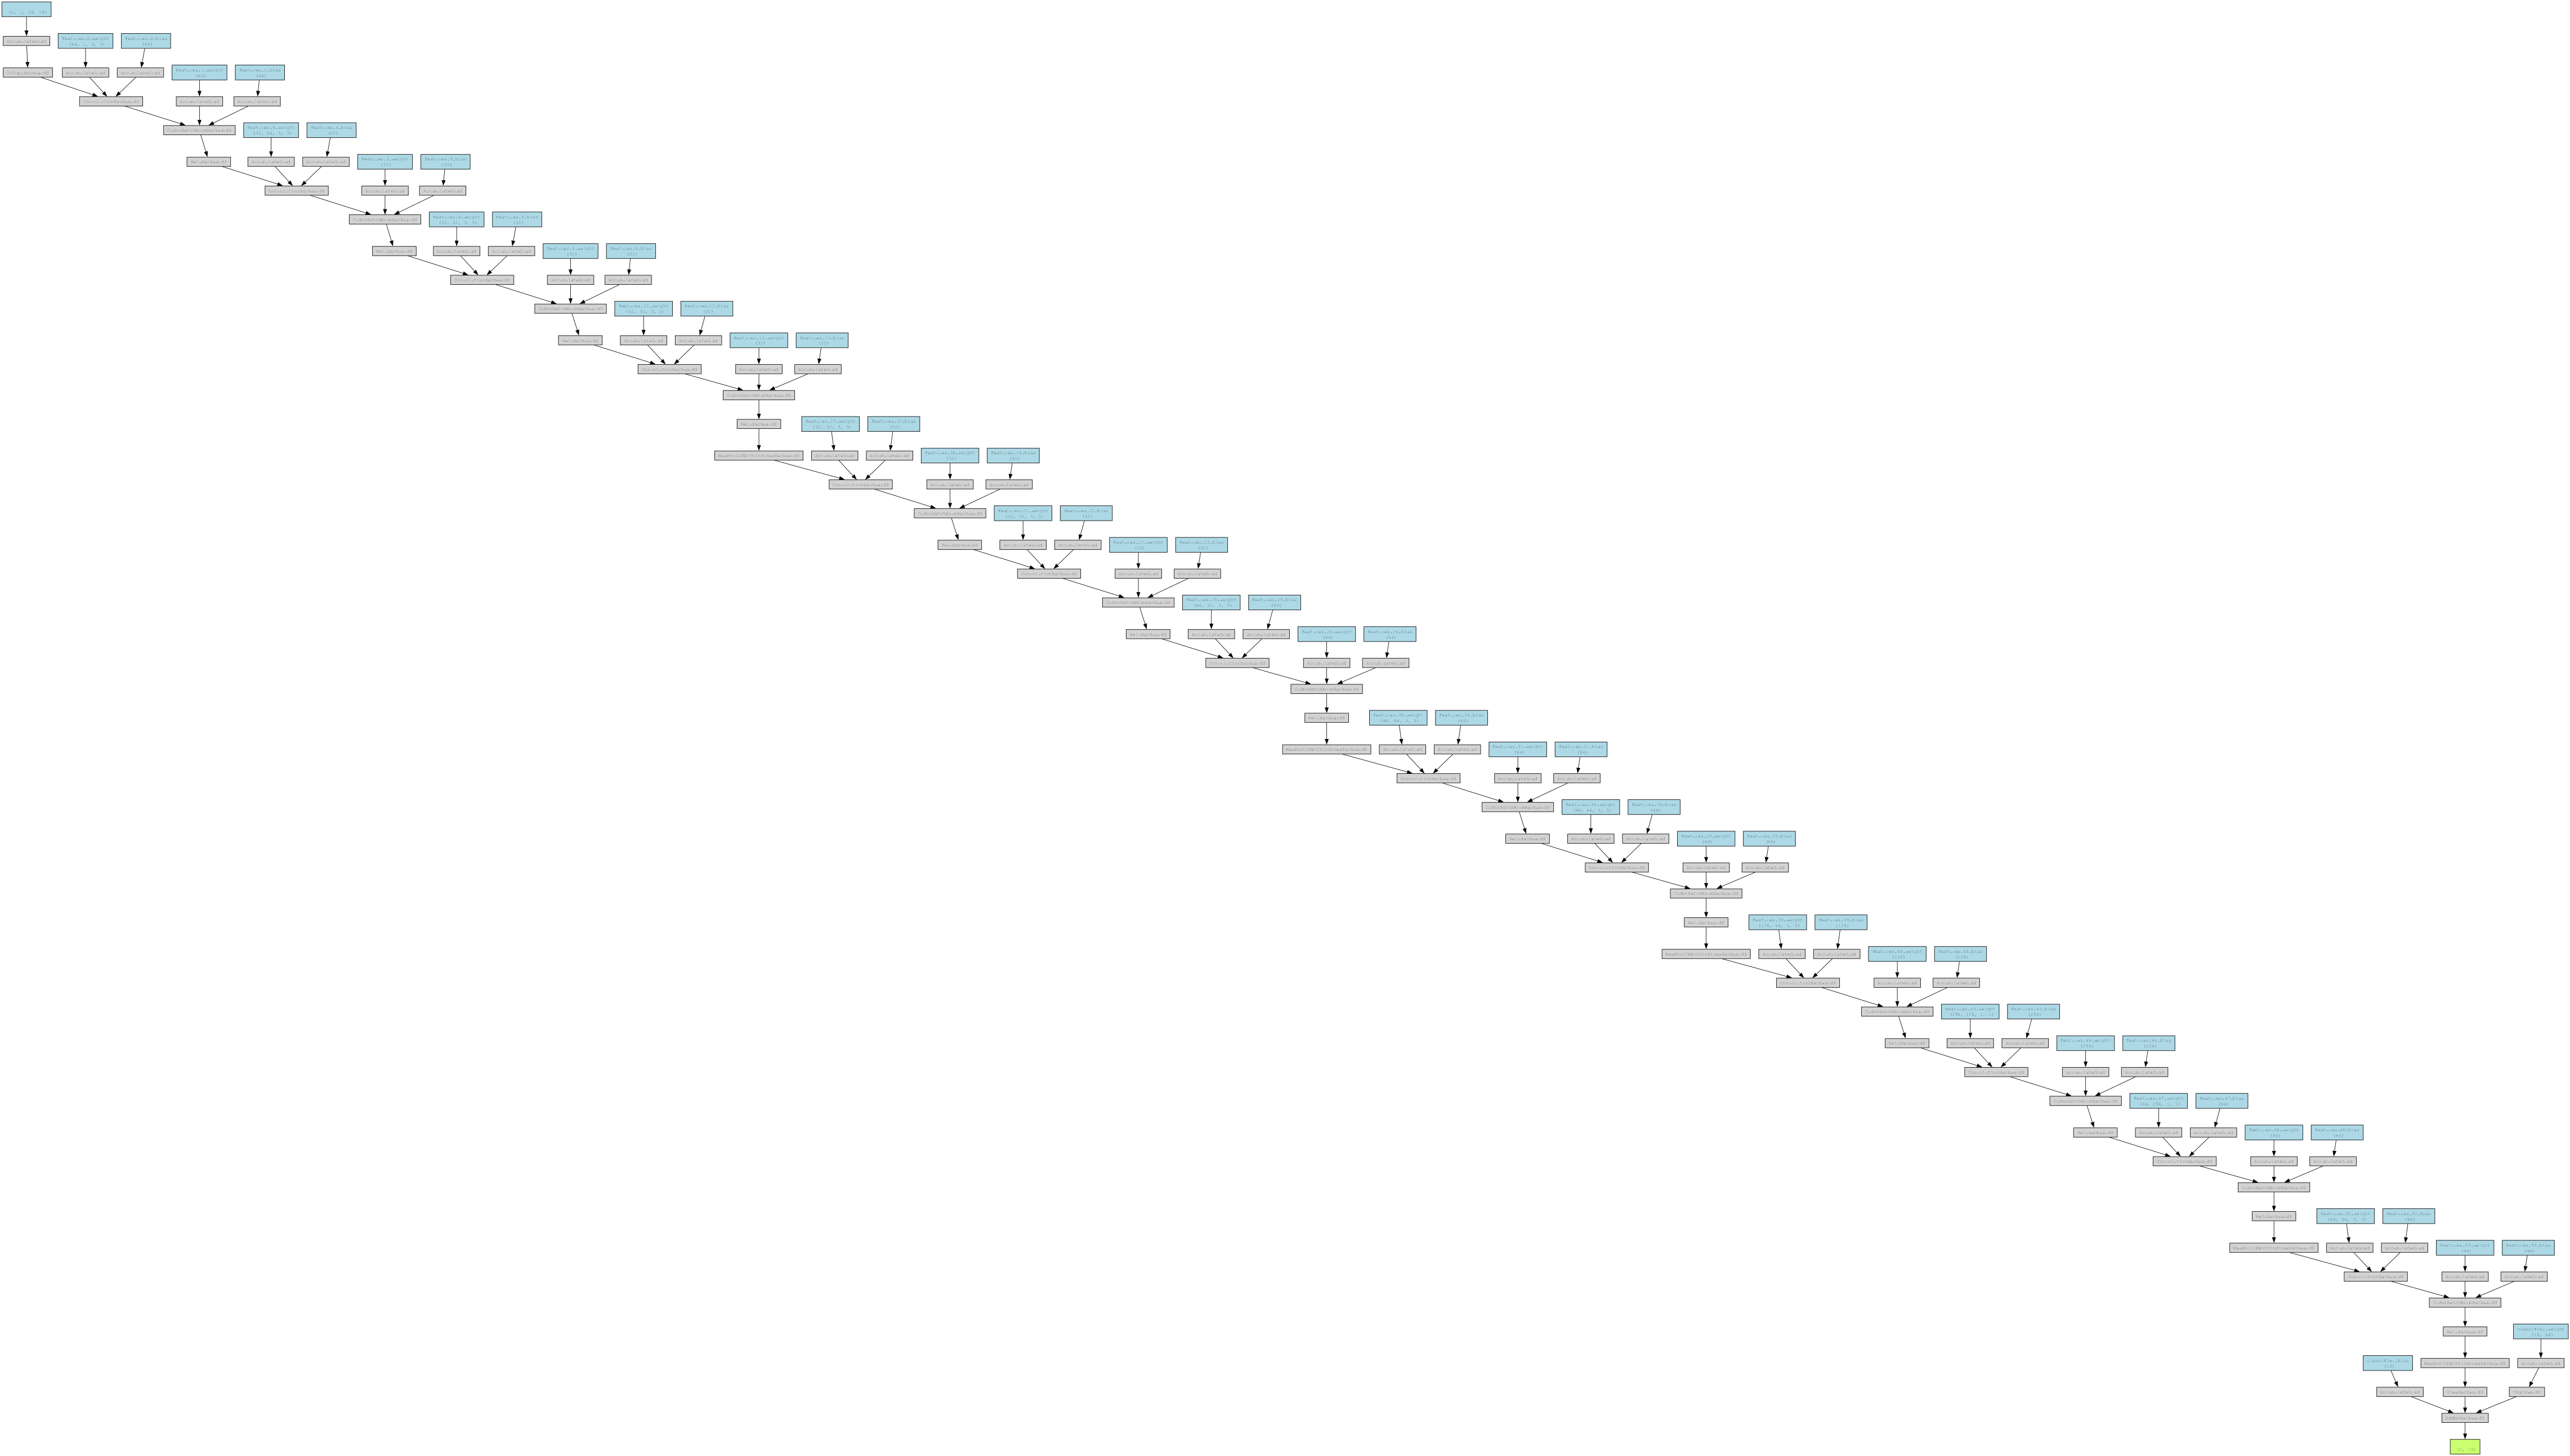

In [ ]:
x = torch.randn(2, 1, 28, 28, requires_grad=True).to(device)
net.eval()
y = net(x)
# Visualize the graph 
make_dot(y, params=dict(list(net.named_parameters()) + [('x', x)]))
# resize_graph(dot, size_per_element=0.15, min_size=12)

In [ ]:
# to save the image as a png
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Create a dummy input tensor
x = torch.randn(2, 1, 28, 28, requires_grad=True).to(device)

# Set the model to evaluation mode
net.eval()

# Perform a forward pass with the dummy input tensor
y = net(x)

# Visualize the computation graph
dot = make_dot(y, params=dict(list(net.named_parameters()) + [('x', x)]))
# To display the visualization, you may need to convert it to a format
# that can be rendered in your environment, such as a PNG or PDF
dot.format = 'png'
dot.engine = 'neato'
dot.render('net_visualization')

'net_visualization.png'

## Vizualizare cu Torchview

[question pe stackoverflow](https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft/47031762#47031762)

```
1) Graphviz – download unzip in a particular place in the system (pip does not work in windows ) and include the bin folder in the path (‘set environment variables in windows’ OR) set manually in each program

import os
os.environ["PATH"] += os.pathsep + 'C:/GraphViz/bin'
2) Then put the model to plot```

Ca sa mearga vizualizarea NN-ului cu torchview, torchviz si alte librarii, trebuie ca `graphviz`, package-ul peste care sunt construite aceste librarii sa se afle local: am downloadat zip-ul cu fisierele bin in ProgramFiles x86 si am facut path append cu comanda de mai jos: 

In [ ]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\Graphviz\bin'

[exemplu in colab](https://colab.research.google.com/github/mert-kurttutan/torchview/blob/main/docs/docs/tutorial/notebook/example_vision.ipynb)

when running on VSCode run the below command svg format on vscode does not give desired result:

use `graphviz.set_jupyter_format('png')`

In [ ]:
graphviz.set_jupyter_format('png')

'png'


(dot.exe:21852): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


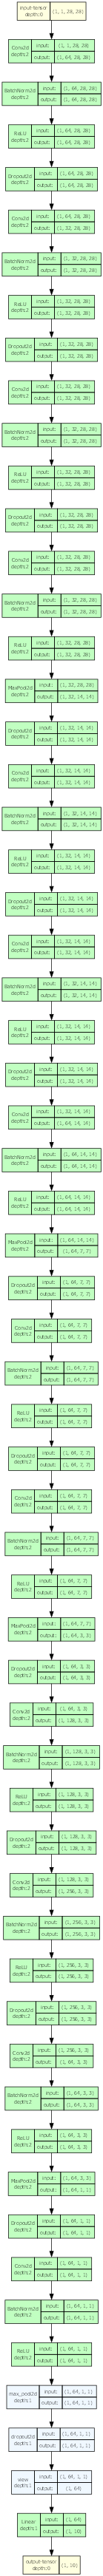

In [ ]:
from torchview import draw_graph
import graphviz

model_graph = draw_graph(net, input_size=(1, 1, 28, 28))
model_graph.visual_graph

## Vizualizare cu Netron

[Netron](https://netron.app/)

> ! Netron requires `onnx` format. 

Convert .pth model to onnx format in order to plot graph in Netron app:

In [17]:
import onnx

net.eval()
# Create a dummy input tensor
dummy_input = torch.randn(1, 1, 28, 28).to(device)

# Export the model to ONNX format
onnx_path = "simplenet.onnx"
torch.onnx.export(net, dummy_input, onnx_path)

print("Model converted to ONNX format and saved as:", onnx_path)

Model converted to ONNX format and saved as: simplenet.onnx
